In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import pickle
import tensorflow as tf
import numpy as np
with open('./expert_data/Ant-v2.pkl', 'rb') as f:
    trace = pickle.load(f)

## Inspect

In [3]:
print('state shape {}'.format(trace['observations'].shape))
print('state example {}'.format(trace['observations'][0]))
print('actions shape {}'.format(trace['actions'].shape))
print('actions example {}'.format(trace['actions'][0]))

state shape (99286, 111)
state example [ 0.71573081  0.99940448  0.02172482  0.01214414 -0.02390038 -0.0665109
  0.01878657 -0.00400649  0.03484956  0.05231029  0.02381142 -0.04922052
  0.06561302  0.00577665 -0.16576287  0.0679862  -0.05062527  0.0702232
 -0.12525527 -0.03925672  0.00716105  0.04726429 -0.10090095 -0.05052721
  0.13599655  0.04025173 -0.04089372  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.     

In [4]:
trace['actions'][0]

array([[ 0.16867521,  0.14678647, -0.98412555,  0.1303245 , -0.3712668 ,
         0.10947994,  0.7155637 ,  0.18452707]], dtype=float32)

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((trace['observations'], trace['actions']))

In [16]:
from behavioral_cloning import *

In [7]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
import gym

In [9]:
env = gym.make('Ant-v2')

loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
iter 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965]
mean return 4851.06744970965
std of return 0.0
iter 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495]
mean return 4783.817809535072
std of return 67.24964017457751
iter 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473]
mean return 4762.470441575872
std of return 62.66122916108258
iter 3
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122]
mean return 4842.663936027435
std of return 149.12347865792827
iter 4
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000

300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606]
mean return 4844.6712964677745
std of return 119.52407466024049
iter 23
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7

100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287]
mean return 4676.38924940453
std of return 652.4421840311882
iter 35
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.24441

200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876]
mean return 4688.743822865075
std of return 584.0107823999391
iter 44
100/

iter 51
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023, 

200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023, 4834.481089449797

200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023, 4834.481089449797

200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023, 4834.481089449797

iter 77
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023, 

iter 82
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023, 

100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023, 4834.481

iter 92
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023, 

200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023, 4834.481089449797

iter 101
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 105
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 109
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 113
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 117
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 121
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 125
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 129
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 133
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023, 4834.481

iter 139
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 142
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 145
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023, 4834.481

iter 151
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 154
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 157
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 160
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 163
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 166
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 169
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 172
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 175
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 178
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 181
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 184
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 187
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 190
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 193
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 196
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 199
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 202
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 205
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 207
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 209
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 211
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 213
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 215
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 217
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 219
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 221
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 223
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 225
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 227
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 229
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 231
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 233
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 235
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 237
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 239
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 241
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 243
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 245
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 247
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 249
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 251
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 253
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 255
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 257
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 259
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 261
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 263
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 265
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 267
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 269
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 271
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 273
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 275
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 277
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 279
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 281
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 283
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 285
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 287
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 289
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 291
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 293
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 295
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 297
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

iter 299
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
returns [4851.06744970965, 4716.568169360495, 4719.775705657473, 5083.244419382122, 5013.483421732236, 4759.669467393927, 4656.812096304318, 4864.041915175698, 5081.009686415594, 4951.548923995156, 4714.944852273602, 4982.5945235399395, 4923.202014606979, 4982.44208511515, 4882.598723326444, 4759.336580492401, 4837.7321299785135, 4790.770872687025, 4790.076795561111, 4762.045939894471, 4772.896400319183, 4744.987935694713, 4786.589710142606, 4986.8566706593065, 4658.711927170917, 4790.10875223973, 4627.138078756099, 3745.443935502429, 4485.212060416937, 4800.021066882979, 4944.097935467624, 4668.50277616584, 4690.505931980357, 1097.1913713362837, 4752.393403821287, 4846.400014159368, 4682.578370830555, 4689.948767269521, 4866.20930866451, 4759.914657183544, 4744.202801531403, 4614.098448666653, 4588.411605874284, 4839.340502724876, 4770.694552991894, 4849.969498059199, 4756.496336822023,

<IPython.core.display.Javascript object>


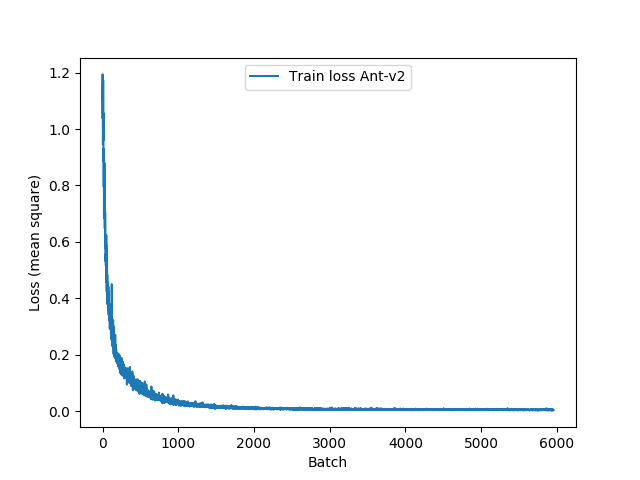

100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000

800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000

900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000

400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000

In [31]:
batch_size = 50
rollouts = 300
max_timesteps = 0 #0 means run until termination

losses = []

#ax = f.subplot(111)

#tasks = ['Hopper-v2', 'Ant-v2', 'HalfCheetah-v2', 'Humanoid-v2', 'Reacher-v2','Walker2d-v2']
tasks = ['Ant-v2']
results = pd.DataFrame(columns=['Task','mean return','std return'])
for task in tasks:
    tf.reset_default_graph()
    with tf.Session() as sess:
        #dataset = get_dataset('./expert_data/{}.pkl'.format(task))
        dataset, expert_returns = get_dataset(envname=task,render=False,expert_policy_file='experts/'+task+'.pkl',max_timesteps=0,num_rollouts=rollouts,store=False)
        obs_dim = dataset.output_shapes[0].as_list()
        action_dim = dataset.output_shapes[1].as_list()[1:]
        batched_dataset = dataset.batch(batch_size)
        iterator = batched_dataset.make_one_shot_iterator()
        next_element = iterator.get_next()
        behavioral_net = BehavioralCloningNet(obs_dim, action_dim, batch_size)
        sess.run(tf.global_variables_initializer())
        losses = behavioral_net.train(next_element)
        #behavioral_net, losses = train_behavioral_network(next_element, obs_dim, action_dim, batch_size)
        #subfig = plt.subplot()
        fig = plt.figure()
        plt.plot(losses)
        plt.xlabel('Batch')
        plt.ylabel('Loss (mean square)')
        plt.legend(['Train loss {}'.format(task)],loc='upper center')
        plt.show(fig)
        evaluate = Evaluate(task,render=False)
        evaluate.step = lambda obs: behavioral_net.predict([obs])

        returns = evaluate.evaluate(rollouts=rollouts)
        results = results.append({'Task': task,
                            'mean return': np.mean(returns),
                            'std return': np.std(returns),
                            'expert mean return': np.mean(expert_returns),
                            'expert std return': np.std(expert_returns)},
                            ignore_index=True)
        #print('returns', returns)
        #print('mean return', np.mean(returns))
        #print('std of return', np.std(returns))


In [32]:
results

,Task,mean return,std return,expert mean return,expert std return
0,Ant-v2,4555.784451,514.57492,4779.158274,329.788041


<IPython.core.display.Javascript object>


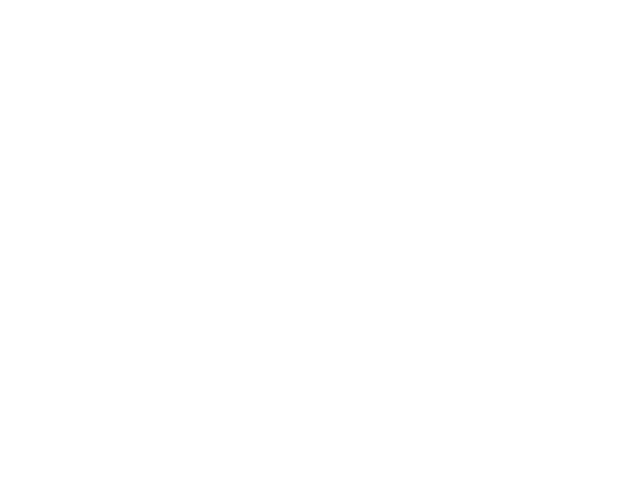

In [12]:
fig = plt.figure()